From notebook 4:

Does the metric attain a higher value for the true mixing f than for inv_darmois,

i.e.  aDM(inv_darmois)>aDM(f) typically?

**A:** **Apparently not**. At least in 2d. Why? Investigate!

In [1]:
#  It might be that high dimensionality is required to see that, typically, aDM(inv_darmois)>aDM(f) 
#  --- with f being the true mixing and inv_darmois the inverse of the Darmois construction:
#  In that case, in order to numerically check it, we need a differentiable implementation of the 
#  Darmois construction in D>2.
#  a) Consider whether it can be extended to D>2? 
#  b) Or whether it makes sense to solve the problem with the differentiable Darmois?

In [2]:
import jax
from jax import numpy as np
from jax import vmap
from jax import jacfwd

from jax import random
key = random.PRNGKey(0)

import numpy as onp

from metrics import aDM

In [3]:
from jax.scipy import special

In [4]:
from plotting import plot_histograms

#### Q: For normal random variables, can we simply implement the Darmois construction with Grahm-Schmidt orthogonalization?

In [5]:
# Maybe to begin with, check whether we can replicate the 2d result?

In [6]:
from mixing_functions import f_g_unl, f_lin

In [7]:
# N:=Number of samples
N = 60000
# D:=Number of dimensions
D = 2

S = random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

In [8]:
from plotting import cart2pol

_, phi = cart2pol( S[:,0]-0.5, S[:,1]-0.5)

colors = phi

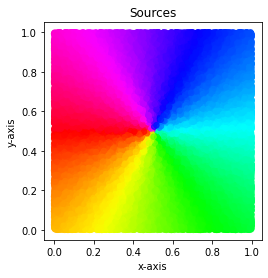

In [9]:
from plotting import scatterplot_variables
scatterplot_variables(S, 'Sources', colors=colors)

In [10]:
A = random.multivariate_normal(key, mean=np.zeros(D*2), cov=np.eye(2*D)).reshape(2,2)
A = np.sqrt(np.abs(A))*np.sign(A)

f_unl, f_unl_inv = f_g_unl(A)

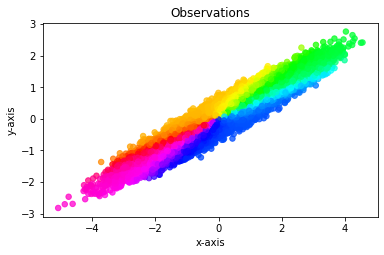

In [11]:
f_unl_batched = vmap(f_unl)

# Observations
X = f_unl_batched(S)
scatterplot_variables(X, 'Observations', colors=colors)

In [12]:
X.shape

(60000, 2)

In [13]:
A_inv = np.linalg.inv(A)

In [14]:
_, R = np.linalg.qr(A_inv)

In [15]:
# Q, _ = np.linalg.qr(A)

In [16]:
T_lin, _ = f_lin(R)
T_lin_batched = vmap(T_lin)

In [17]:
X_ = T_lin_batched(X)

In [18]:
Y = 0.5*(1.0 + special.erf(X_))

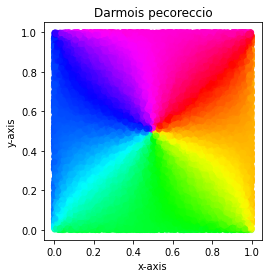

In [19]:
scatterplot_variables(Y, 'Darmois pecoreccio', colors=colors)

In [20]:
from mixing_functions import darmois_linear_gaussian

In [21]:
darmois, inv_darmois = darmois_linear_gaussian(A)

In [22]:
darmois_batched = vmap(darmois)

In [23]:
Y_d = darmois_batched(X)

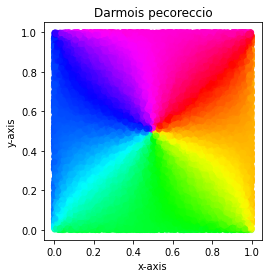

In [24]:
scatterplot_variables(Y_d, 'Darmois pecoreccio', colors=colors)

In [25]:
# Compute the Jacobian of both

In [26]:
from mixing_functions import darmois_linear_gaussian_2d

In [27]:
darmois_2d, inv_darmois_2d = darmois_linear_gaussian_2d(A)

In [28]:
darmois_2d_batched = vmap(darmois_2d)

In [29]:
Y_2d = darmois_2d_batched(X)

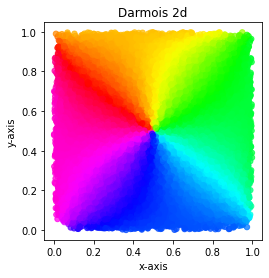

In [30]:
scatterplot_variables(Y_2d, 'Darmois 2d', colors=colors)

In [31]:
# Compute the Jacobian of both

# Urk! What's wrong there? There's a discrepancy; which one's right?

# Also, compute the Jacobian of both!

**Q: For the true mixing function**, how does aDM change as $D$ grows?

(Only for the true mixing for now; we at the moment don't have the closed form Darmois for $D>2$).

In [32]:
# N:=Number of samples
N = 6000
# D:=Number of dimensions
Dims = [2, 3, 5, 10, 15]#, 30, 50]

In [33]:
# Darmois construction
from mixing_functions import darmois_linear_gaussian

from scipy.stats import ortho_group

reps = 3*10**2

# Accumulate metric values for histograms
true_aDM_s = onp.zeros((reps, len(Dims)))
darmois_aDM_s = onp.zeros((reps, len(Dims)))

In [34]:
# How many times do we "spot" the Darmois construction?
positive = onp.zeros(len(Dims))

for idx, Dim in enumerate(Dims):
    # Generate the samples
    S = random.uniform(key, shape=(N, Dim), minval=0.0, maxval=1.0)
    for i in range(reps):

        # Generate mixing
        A = random.multivariate_normal(key, mean=np.zeros(Dim*Dim), cov=np.eye(Dim*Dim)).reshape(Dim,Dim)
#         A = ortho_group.rvs(dim=Dim)

        # Nonlinear mixing (uniform to normal then linearly mixed)
        f, _ = f_g_unl(A)
        f_batched = vmap(f)
        
        # Compute observations
        X = f_batched(S)
        
        # Compute the batched Jacobian
        Jf = jacfwd(f)
        Jf_batched = vmap(Jf)
        # Compute aDM
        # NOTE THAT THIS HAS TO BE APPLIED TO THE UNIFORM R.V.'s S
        true_aDM = aDM(Jf_batched, S)
        
        # Darmois
        darmois, inv_darmois = darmois_linear_gaussian(A)
        darmois_batched, inv_darmois_batched = vmap(darmois), vmap(inv_darmois)      
        
        # Sources w. Darmois construction
        Y = darmois_batched(X)

        # Compute the batched Jacobian
        Jinv_darmois = jacfwd(inv_darmois)
        Jinv_darmois_batched = vmap(Jinv_darmois)
        # Compute aDM for inv Darmois
        inv_darmois_aDM = aDM(Jinv_darmois_batched, Y)
        
        if true_aDM < inv_darmois_aDM:
            positive[idx]+=1
        
        true_aDM_s[i, idx] = true_aDM
        darmois_aDM_s[i, idx] = inv_darmois_aDM
        
        # Update random key
        key+=1
        
    print("Dimension =", Dim, "; success rate=", positive[idx]/reps)

Dimension = 2 ; success rate= 0.35333333333333333
Dimension = 3 ; success rate= 0.21666666666666667
Dimension = 5 ; success rate= 0.06333333333333334
Dimension = 10 ; success rate= 0.0033333333333333335
Dimension = 15 ; success rate= 0.0


16.986513


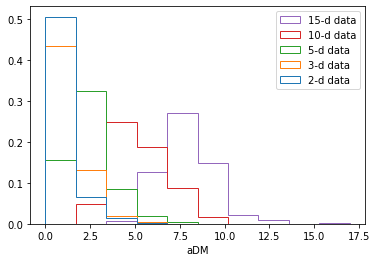

In [35]:
hist_values = [true_aDM_s[:, i] for i in range(len(Dims))]
labels = [str(a)+"-d data" for a in Dims]

plot_histograms(hist_values,
               labels,
               'aDM')

print(np.max(true_aDM_s))

nan


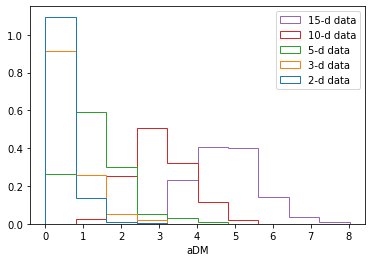

In [36]:
hist_values = [darmois_aDM_s[:, i] for i in range(len(Dims))]
labels = [str(a)+"-d data" for a in Dims]

plot_histograms(hist_values,
               labels,
               'aDM')


print(np.min(darmois_aDM_s))

# Ouch!

In [37]:
np.max(darmois_aDM_s)

DeviceArray(nan, dtype=float32)

# Why are there nan's?